In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_dir = "dataset/train"
test_dir = "dataset/test"

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    classes=selected_classes,
    subset="training"
)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    classes=selected_classes,
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    classes=selected_classes
)

Found 16939 images belonging to 4 classes.
Found 4233 images belonging to 4 classes.
Found 7928 images belonging to 4 classes.


In [13]:
import os
selected_classes=["angry","happy","sad","neutral"]
for emotion in selected_classes:
    count = len(os.listdir(os.path.join(train_dir, emotion)))
    print(f"{emotion}: {count} images")

angry: 5295 images
happy: 5296 images
sad: 5299 images
neutral: 5282 images


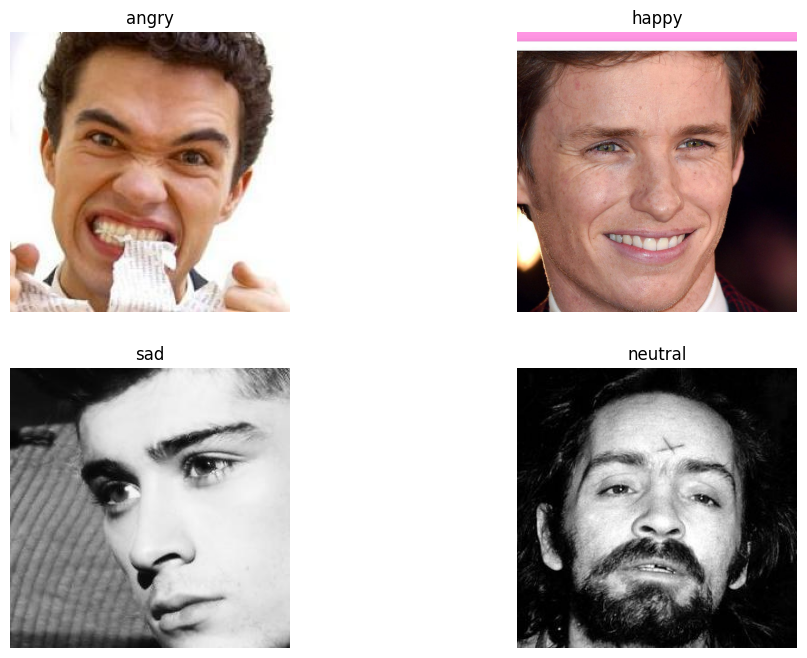

In [14]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(12,8))

for i, emotion in enumerate(selected_classes):
    img_path = os.path.join(train_dir, emotion, random.choice(os.listdir(os.path.join(train_dir, emotion))))
    img = plt.imread(img_path)

    plt.subplot(2,2,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(emotion)
    plt.axis("off")

plt.show()


In [15]:
img.shape

(309, 309, 3)

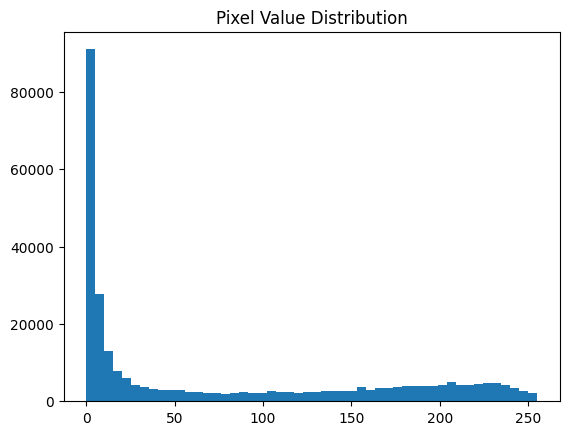

In [16]:
plt.hist(img.flatten(), bins=50)
plt.title("Pixel Value Distribution")
plt.show()

In [17]:
train_generator.class_indices

{'angry': 0, 'happy': 1, 'sad': 2, 'neutral': 3}

In [18]:
import numpy as np
from collections import Counter

labels = train_generator.classes
Counter(labels)

Counter({2: 4240, 1: 4237, 0: 4236, 3: 4226})

In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.999704910292729,
 1: 0.9994689638895445,
 2: 0.9987617924528301,
 3: 1.0020705158542358}

In [20]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.models import Sequential

# Block 1
model = Sequential([tf.keras.Input(shape=(48,48,1))])
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(512,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu') )
model.add(Dropout(0.5) )
model.add(Dense(4, activation='softmax'))

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

2026-02-21 00:03:17.388772: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-02-21 00:03:17.388935: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-21 00:03:17.388941: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2026-02-21 00:03:17.389165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-21 00:03:17.389187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,734,596 (10.43 MB)

 Trainable params: 2,732,676 (10.42 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_emotion_model.h5",
    monitor='val_accuracy',
    save_best_only=True
)

In [22]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50


2026-02-21 00:03:21.411448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2605 - loss: 7.9616

265/265 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - accuracy: 0.2670 - loss: 8.5066 - val_accuracy: 0.2499 - val_loss: 2.1035
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2674 - loss: 8.5801

265/265 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.2662 - loss: 8.2922 - val_accuracy: 0.2894 - val_loss: 1.9635
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2787 - loss: 7.0783

265/265 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.2763 - loss: 6.6671 - val_accuracy: 0.3296 - val_loss: 1.7286
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2767 - loss: 5.2175

265/265 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - accuracy: 0.2784 - loss: 4.7707 - val_accuracy: 0.3414 - val_loss: 1.5692
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2811 - loss: 3.5515

265/265 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.2802 - loss: 3.1325 - val_accuracy: 0.3721 - val_loss: 1.3278
Epoch 6/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - accuracy: 0.2974 - loss: 1.8339 - val_accuracy: 0.3669 - val_loss: 1.3261
Epoch 7/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.3177 - loss: 1.4196 - val_accuracy: 0.3650 - val_loss: 1.3263
Epoch 8/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3386 - loss: 1.3661

265/265 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.3413 - loss: 1.3577 - val_accuracy: 0.4063 - val_loss: 1.2661
Epoch 9/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3659 - loss: 1.3402

265/265 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.3695 - loss: 1.3234 - val_accuracy: 0.4184 - val_loss: 1.2242
Epoch 10/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3954 - loss: 1.2774

265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.4030 - loss: 1.2684 - val_accuracy: 0.4439 - val_loss: 1.1820
Epoch 11/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4217 - loss: 1.2355

265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.4262 - loss: 1.2253 - val_accuracy: 0.4918 - val_loss: 1.1146
Epoch 12/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.4425 - loss: 1.2027 - val_accuracy: 0.4874 - val_loss: 1.0993
Epoch 13/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4629 - loss: 1.1640

265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - accuracy: 0.4657 - loss: 1.1625 - val_accuracy: 0.5072 - val_loss: 1.0917
Epoch 14/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4837 - loss: 1.1459

265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.4800 - loss: 1.1439 - val_accuracy: 0.5207 - val_loss: 1.0483
Epoch 15/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4802 - loss: 1.1414

265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.4857 - loss: 1.1392 - val_accuracy: 0.5266 - val_loss: 1.0560
Epoch 16/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5067 - loss: 1.1121

265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.5040 - loss: 1.1140 - val_accuracy: 0.5384 - val_loss: 1.0444
Epoch 17/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.5150 - loss: 1.0925 - val_accuracy: 0.5282 - val_loss: 1.0615
Epoch 18/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5209 - loss: 1.0852

265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.5197 - loss: 1.0868 - val_accuracy: 0.5627 - val_loss: 0.9984
Epoch 19/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.5303 - loss: 1.0636 - val_accuracy: 0.5563 - val_loss: 1.0217
Epoch 20/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5361 - loss: 1.0571

265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.5413 - loss: 1.0522 - val_accuracy: 0.5686 - val_loss: 0.9832
Epoch 21/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.5421 - loss: 1.0443 - val_accuracy: 0.5663 - val_loss: 0.9936
Epoch 22/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5408 - loss: 1.0467

265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.5502 - loss: 1.0343 - val_accuracy: 0.5762 - val_loss: 0.9755
Epoch 23/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.5558 - loss: 1.0196 - val_accuracy: 0.5493 - val_loss: 1.0510
Epoch 24/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.5624 - loss: 1.0221 - val_accuracy: 0.5750 - val_loss: 0.9697
Epoch 25/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.5650 - loss: 1.0084 - val_accuracy: 0.5646 - val_loss: 0.9918
Epoch 26/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5710 - loss: 0.9940

265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - accuracy: 0.5737 - loss: 0.9971 - val_accuracy: 0.5873 - val_loss: 0.9607
Epoch 27/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5803 - loss: 0.9901

265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.5771 - loss: 0.9938 - val_accuracy: 0.5944 - val_loss: 0.9333
Epoch 28/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.5816 - loss: 0.9841 - val_accuracy: 0.5471 - val_loss: 1.0157
Epoch 29/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.5744 - loss: 0.9873 - val_accuracy: 0.5809 - val_loss: 0.9693
Epoch 30/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5854 - loss: 0.9711

265/265 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step - accuracy: 0.5856 - loss: 0.9720 - val_accuracy: 0.6043 - val_loss: 0.9188
Epoch 31/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - accuracy: 0.5894 - loss: 0.9771 - val_accuracy: 0.6022 - val_loss: 0.9265
Epoch 32/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5916 - loss: 0.9767

265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.5874 - loss: 0.9760 - val_accuracy: 0.6163 - val_loss: 0.9229
Epoch 33/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.5904 - loss: 0.9640 - val_accuracy: 0.5840 - val_loss: 0.9624
Epoch 34/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.5977 - loss: 0.9580 - val_accuracy: 0.5816 - val_loss: 0.9698
Epoch 35/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.5894 - loss: 0.9620 - val_accuracy: 0.5937 - val_loss: 0.9655
Epoch 36/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.5944 - loss: 0.9617 - val_accuracy: 0.5998 - val_loss: 0.9345
Epoch 37/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.5914 - loss: 0.9667 - val_accuracy: 0.5911 - val_loss: 0.9430
Epoch 38/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5965 - loss: 0.9474

265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - accuracy: 0.6002 - loss: 0.9417 - val_accuracy: 0.6182 - val_loss: 0.9038
Epoch 39/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 45s 171ms/step - accuracy: 0.5953 - loss: 0.9548 - val_accuracy: 0.5989 - val_loss: 0.9468
Epoch 40/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.6042 - loss: 0.9449 - val_accuracy: 0.5764 - val_loss: 0.9648
Epoch 41/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.6027 - loss: 0.9432 - val_accuracy: 0.6010 - val_loss: 0.9083
Epoch 42/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.6033 - loss: 0.9400 - val_accuracy: 0.6112 - val_loss: 0.9230
Epoch 43/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.6049 - loss: 0.9408 - val_accuracy: 0.5752 - val_loss: 0.9817
Epoch 44/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 42s 158ms/step - accuracy: 0.6033 - loss: 0.9461 - val_accuracy: 0.6133 - val_loss: 0.9098
Epoch 45/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6145 - loss: 0.9291

265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.6068 - loss: 0.9373 - val_accuracy: 0.6197 - val_loss: 0.8945
Epoch 46/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.6153 - loss: 0.9254 - val_accuracy: 0.5918 - val_loss: 0.9681
Epoch 47/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step - accuracy: 0.6140 - loss: 0.9288 - val_accuracy: 0.5908 - val_loss: 0.9802
Epoch 48/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - accuracy: 0.6145 - loss: 0.9333 - val_accuracy: 0.6022 - val_loss: 0.9322
Epoch 49/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.6082 - loss: 0.9372 - val_accuracy: 0.6154 - val_loss: 0.8966
Epoch 50/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6199 - loss: 0.9226

265/265 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.6163 - loss: 0.9220 - val_accuracy: 0.6284 - val_loss: 0.8664


In [23]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6615 - loss: 0.8073
Test Accuracy: 0.6614530682563782


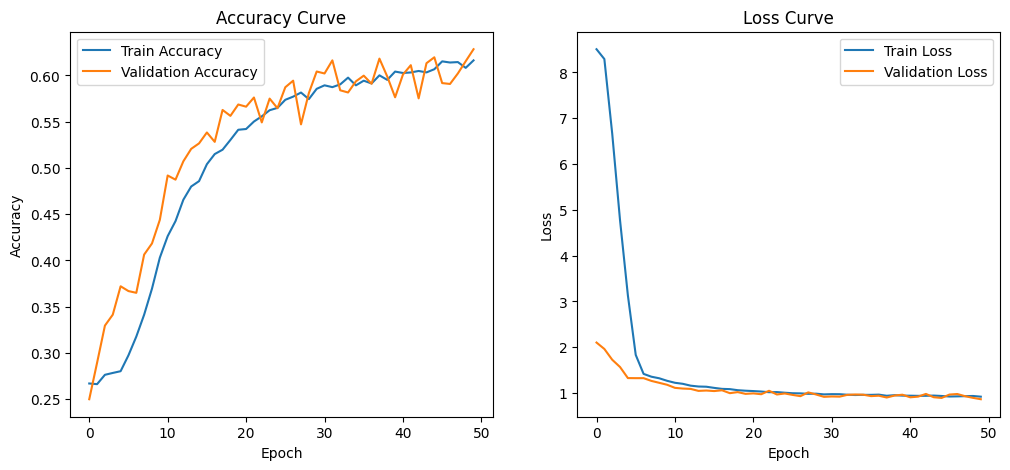

In [24]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [25]:
import numpy as np

test_generator.reset()
predictions = model.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step


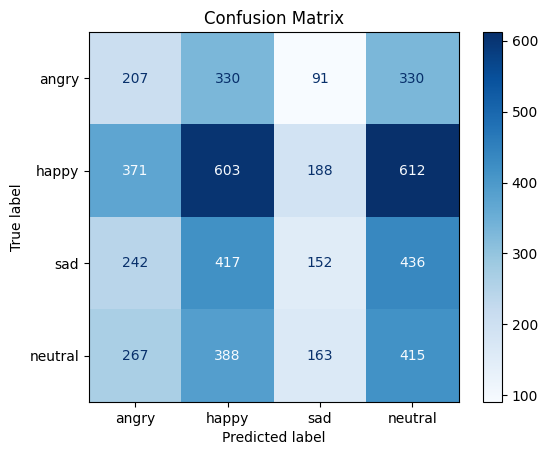

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

labels = list(test_generator.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [127]:
model.save("emotion_model.keras")